# Sentiment Analysis
Importing all the necessary libraries and packeges required.

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer, KNNImputer
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
!pip install transformers

Loading the dataset

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/reviews.xlsx'
df = pd.read_excel(file_path)
print(df.head())

   Unnamed: 0   Airline Name Overall_Rating  \
0           0    AB Aviation              9   
1           1    AB Aviation              1   
2           2    AB Aviation              1   
3           3  Adria Airways              1   
4           4  Adria Airways              1   

                            Review_Title          Review Date  Verified  \
0                "pretty decent airline"   11th November 2019      True   
1                   "Not a good airline"       25th June 2019      True   
2         "flight was fortunately short"       25th June 2019      True   
3    "I will never fly again with Adria"  28th September 2019     False   
4  "it ruined our last days of holidays"  24th September 2019      True   

                                              Review       Aircraft  \
0    Moroni to Moheli. Turned out to be a pretty ...            NaN   
1   Moroni to Anjouan. It is a very small airline...           E120   
2    Anjouan to Dzaoudzi. A very small airline an... 

# Explanatory Data Analysis(EDA)

In [ ]:
df.shape

(23171, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              23171 non-null  int64         
 1   Airline Name            23171 non-null  object        
 2   Overall_Rating          23171 non-null  object        
 3   Review_Title            23171 non-null  object        
 4   Review Date             23171 non-null  object        
 5   Verified                23171 non-null  bool          
 6   Review                  23171 non-null  object        
 7   Aircraft                7129 non-null   object        
 8   Type Of Traveller       19433 non-null  object        
 9   Seat Type               22075 non-null  object        
 10  Route                   19343 non-null  object        
 11  Date Flown              19417 non-null  datetime64[ns]
 12  Seat Comfort            19016 non-null  float6

In [ ]:
df['Overall_Rating'].value_counts()

,count
Overall_Rating,
1,11595
2,2296
9,1768
8,1757
3,1356
7,1192
4,859
n,842
5,830


In [ ]:
# Replacing n with 0
df['Overall_Rating'] = df['Overall_Rating'].replace('n', '0')
df['Overall_Rating'].value_counts()

,count
Overall_Rating,
1,11595
2,2296
9,1768
8,1757
3,1356
7,1192
4,859
0,842
5,830


In [ ]:
# Converting 'Overall_Rating' to integers
df['Overall_Rating'] = pd.to_numeric(df['Overall_Rating'], downcast='integer')

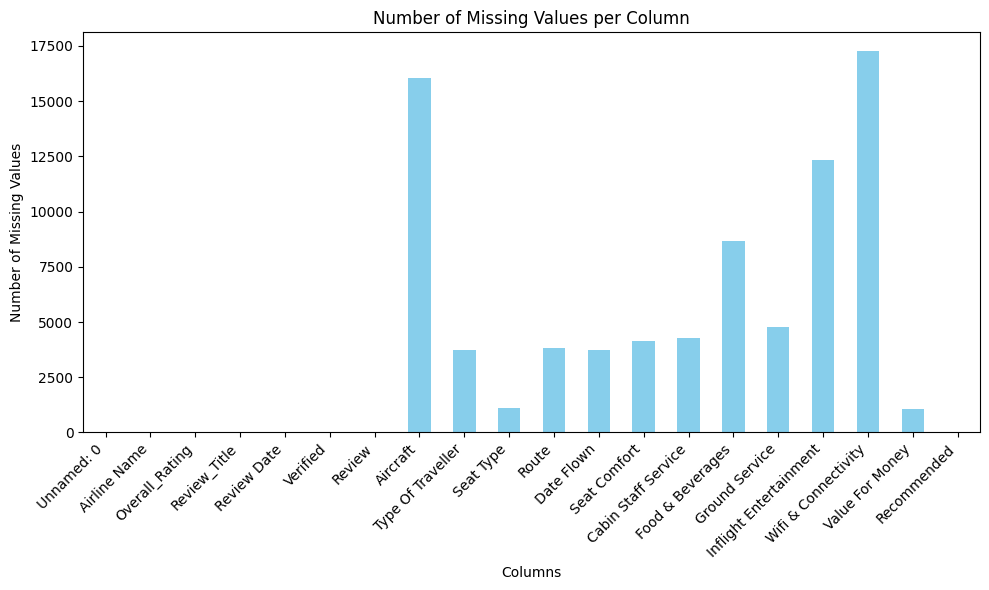

In [ ]:
# Bar chart to visualize the missing values per column
missing_values = df.isnull().sum()
plt.figure(figsize=(10,6))
missing_values.plot(kind='bar', color='skyblue')
plt.title('Number of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Preprocessing

In [ ]:
# Droping rows with missing reviews
df.dropna(subset=['Review','Value For Money'], inplace=True)

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
Airline Name,0
Overall_Rating,0
Review_Title,0
Review Date,0
Verified,0
Review,0
Aircraft,14976
Type Of Traveller,2675
Seat Type,42


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22105 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              22105 non-null  int64         
 1   Airline Name            22105 non-null  object        
 2   Overall_Rating          22105 non-null  int8          
 3   Review_Title            22105 non-null  object        
 4   Review Date             22105 non-null  object        
 5   Verified                22105 non-null  bool          
 6   Review                  22105 non-null  object        
 7   Aircraft                7129 non-null   object        
 8   Type Of Traveller       19430 non-null  object        
 9   Seat Type               22063 non-null  object        
 10  Route                   19340 non-null  object        
 11  Date Flown              19415 non-null  datetime64[ns]
 12  Seat Comfort            19016 non-null  float64    

In [ ]:
# Droping irrelevant columns
df.drop(columns=['Unnamed: 0','Review Date', 'Aircraft','Review_Title',
                 'Type Of Traveller', 'Seat Type', 'Route', 'Date Flown'], inplace=True)

In [ ]:
#Dropping the rows which 'Food & Beverages' is null.
df = df.dropna(axis = 0, subset = ['Food & Beverages','Ground Service','Cabin Staff Service','Seat Comfort'])

In [ ]:
# Creating binary indicators for highly missing data while keeping the original columns
for column in ['Inflight Entertainment', 'Wifi & Connectivity']:
    # Create a new column in df to indicate missingness
    df[column + '_missing'] = df[column].isnull().astype(int)

print(df.head())
print(df[['Inflight Entertainment', 'Inflight Entertainment_missing',
         'Wifi & Connectivity', 'Wifi & Connectivity_missing']].head())

    Airline Name  Overall_Rating  Verified  \
0    AB Aviation               9      True   
1    AB Aviation               1      True   
2    AB Aviation               1      True   
4  Adria Airways               1      True   
5  Adria Airways               1      True   

                                              Review  Seat Comfort  \
0    Moroni to Moheli. Turned out to be a pretty ...           4.0   
1   Moroni to Anjouan. It is a very small airline...           2.0   
2    Anjouan to Dzaoudzi. A very small airline an...           2.0   
4   Do not book a flight with this airline! My fr...           1.0   
5    Had very bad experience with rerouted and ca...           1.0   

   Cabin Staff Service  Food & Beverages  Ground Service  \
0                  5.0               4.0             4.0   
1                  2.0               1.0             1.0   
2                  1.0               1.0             1.0   
4                  1.0               1.0             1.0   
5 

<ipython-input-16-01941c0f0dbb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_missing'] = df[column].isnull().astype(int)
<ipython-input-16-01941c0f0dbb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_missing'] = df[column].isnull().astype(int)


In [ ]:
# Simple Imputation for Inflight Entertainment and Wifi & Connectivity
# We use a constant like -1 to denote missing values since these are ordinal ratings
simple_imputer = SimpleImputer(strategy='constant', fill_value=-1)
df[['Inflight Entertainment', 'Wifi & Connectivity']] = simple_imputer.fit_transform(
    df[['Inflight Entertainment', 'Wifi & Connectivity']])

df.isnull().sum()

,0
Airline Name,0
Overall_Rating,0
Verified,0
Review,0
Seat Comfort,0
Cabin Staff Service,0
Food & Beverages,0
Ground Service,0
Inflight Entertainment,0
Wifi & Connectivity,0


This graph shows 'Overall_Rating' for verified (True) and unverified (False) reviews.

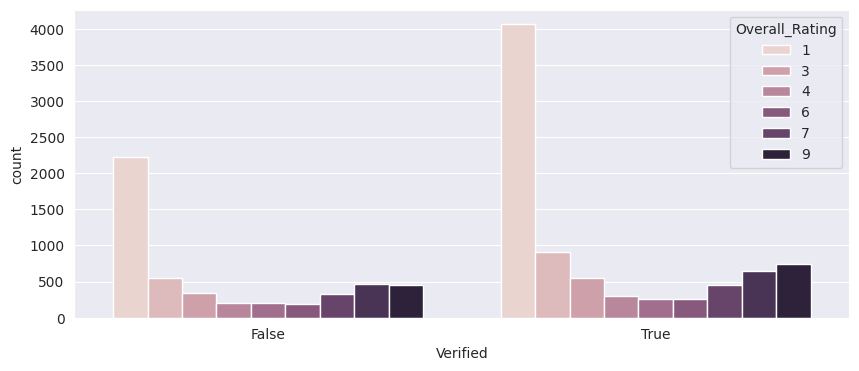

In [ ]:
sns.set_style("darkgrid")
sns.set_palette("viridis")
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(data=df, x='Verified', hue='Overall_Rating', ax=ax)
plt.show()

 we will focus only on the verified reviews to ensure data reliability.

In [ ]:
# Filtering the dataset to include only verified reviews
df = df[df['Verified'] == True]

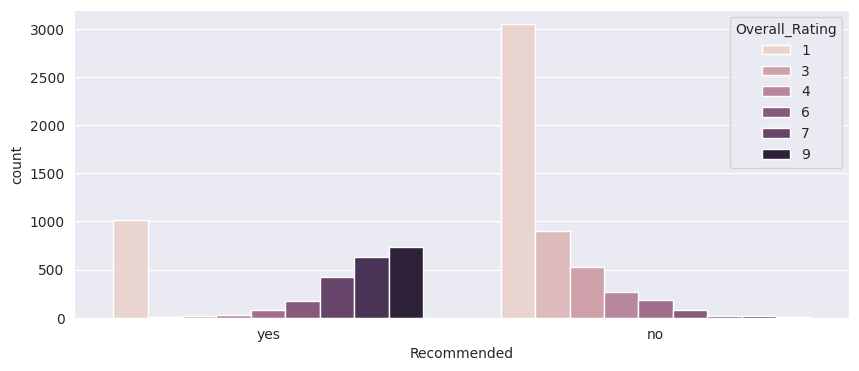

In [ ]:
sns.set_style("darkgrid")
sns.set_palette("viridis")
fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(data=df, x='Recommended', hue='Overall_Rating', ax=ax)
plt.show()

From the above graph, we can see that around 1000 people wrote terrible reviews and still recommend the airline. This could be due to various reasons.
The reviewer may have had a positive experience altogether but may have faced a critical issue that made them give a bad review, like they had good food, wifi, seat comfort, and all but may have faced bad cabin staff service which made them give the bad review.
For this type of scenario, we can use topic modeling which will help us to identify the driving factor for the sentiment the review has.





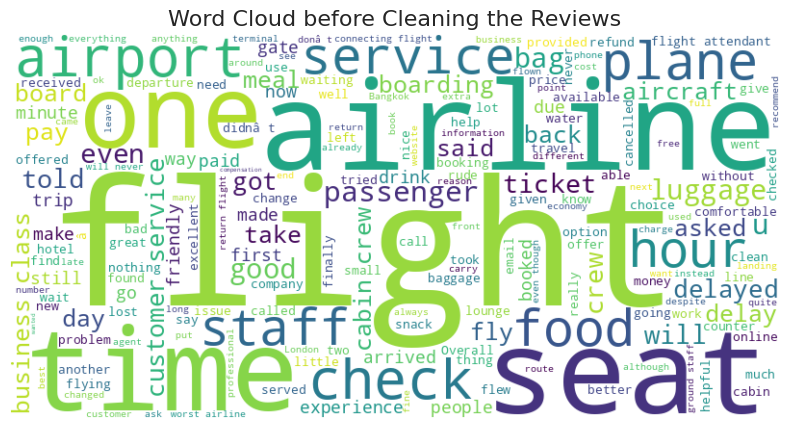

In [ ]:
# Generating a word cloud before cleaning the reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
    ' '.join(df['Review']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud before Cleaning the Reviews', fontsize=16)
plt.show()

# Cleaning the reviews

In [ ]:
# Downloading stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Removing non-alphanumeric characters
    text = text.lower()  # Converting to lowercase
    text = word_tokenize(text)  # Tokenizing the text
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text
            if word not in stopwords.words('english')]  # Remove stopwords and lemmatize
    return ' '.join(text)

# Applying the preprocessing function to the 'Review' column
df['Cleaned_Review'] = df['Review'].apply(clean_text)

print(df[['Review', 'Cleaned_Review']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                              Review  \
0    Moroni to Moheli. Turned out to be a pretty ...   
1   Moroni to Anjouan. It is a very small airline...   
2    Anjouan to Dzaoudzi. A very small airline an...   
4   Do not book a flight with this airline! My fr...   
5    Had very bad experience with rerouted and ca...   

                                      Cleaned_Review  
0  moroni moheli turned pretty decent airline onl...  
1  moroni anjouan small airline ticket advised tu...  
2  anjouan dzaoudzi small airline airline based c...  
4  book flight airline friend returned sofia amst...  
5  bad experience rerouted cancelled flight last ...  


In [ ]:
# Vectorizing the text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000,stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Cleaned_Review'])

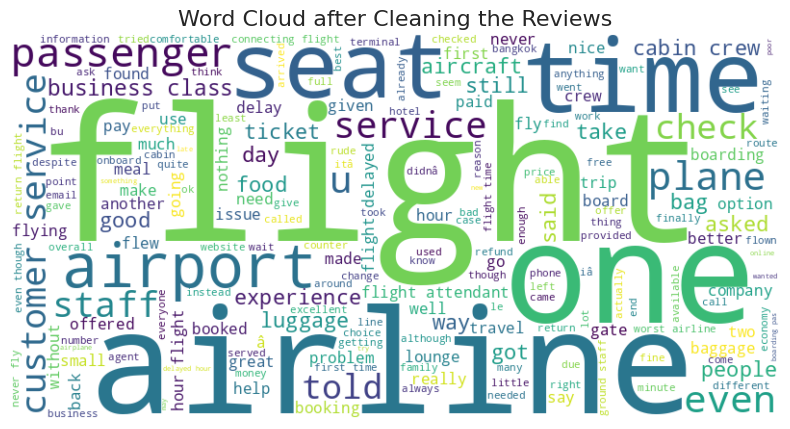

In [ ]:
# word cloud after cleaning the review
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
    ' '.join(df['Cleaned_Review']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud after Cleaning the Reviews', fontsize=16)
plt.show()

# Implementing a Logistic Regression Model
## Sentiment Labeling
Now we are labeling each review with a sentiment score such as positive, negative, or neutral using a pre-built sentiment analysis tool VADER.

In [ ]:
nltk.download('vader_lexicon')
# Initializing VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Applying sentiment analysis to each review
df['sentiment_score'] = df['Cleaned_Review'].apply(
    lambda review: sid.polarity_scores(review)['compound'])

# Categorizing sentiment into positive, negative, or neutral
df['sentiment'] = df['sentiment_score'].apply(lambda score: 'positive' if score
                                              > 0.05 else 'negative' if score
                                              < -0.05 else 'neutral')

print(df[['Cleaned_Review', 'sentiment_score', 'sentiment']].head())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                                      Cleaned_Review  sentiment_score  \
0  moroni moheli turned pretty decent airline onl...           0.9217   
1  moroni anjouan small airline ticket advised tu...          -0.0258   
2  anjouan dzaoudzi small airline airline based c...           0.8122   
4  book flight airline friend returned sofia amst...           0.6249   
5  bad experience rerouted cancelled flight last ...          -0.5267   

  sentiment  
0  positive  
1   neutral  
2  positive  
4  positive  
5  negative  


# Sentiment Prediction

In [ ]:
# Encoding the sentiment labels
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

# Splitting the data for sentiment prediction
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix,
                                                    df['sentiment_encoded'],
                                                    test_size=0.2,
                                                    random_state=42)

# Initialize Logistic Regression classifier
classifier = LogisticRegression(random_state=42)

classifier.fit(X_train, y_train)

# Predicting sentiments on the test set
y_pred = classifier.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Sentiment Prediction Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Sentiment Prediction Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.87      0.84       689
     neutral       0.00      0.00      0.00        33
    positive       0.88      0.87      0.87       913

    accuracy                           0.85      1635
   macro avg       0.57      0.58      0.57      1635
weighted avg       0.84      0.85      0.84      1635

Confusion Matrix:
[[600   0  89]
 [ 15   0  18]
 [121   0 792]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Topic Modeling
Applying topic modeling using Latent Dirichlet Allocation (LDA) to identify the key topics within the reviews.

In [ ]:
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(tfidf_matrix)

# Displaying the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[
            :-no_top_words - 1:-1]]))

no_top_words = 10
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(lda, tfidf_feature_names, no_top_words)


Topic 1:
5hrs vueling ravn la der austin die da pour underwhelming
Topic 2:
flight seat good crew food cabin service meal time class
Topic 3:
windhoek nepal fuzhou sriwijaya virus namibia sultan nur joon yogyakarta
Topic 4:
garuda escorted indonesia volotea et panama vip ga penang est
Topic 5:
stroller sofia shape bulgaria fco quito paulo pet sao im
Topic 6:
southern rex thank staff guangzhou china helped service crew helpful
Topic 7:
maroc casablanca royal cleanliness bandar zip seri ke belfast begawan
Topic 8:
addis ethiopian ababa 15kg siem reap antalya kwi iran lome
Topic 9:
fiji makassar nadi adria tunis ljubljana screwed cana sorong kota
Topic 10:
flight airline hour luggage time customer bag airport service day


Analyzing the relationship between identified topics and sentiment.

sentiment       negative  neutral  positive
dominant_topic                             
0                    8.0      1.0       0.0
1                  423.0     41.0    2940.0
3                    2.0      0.0       5.0
5                    1.0      0.0      81.0
7                    0.0      0.0       1.0
8                    1.0      0.0       0.0
9                 2969.0    104.0    1597.0


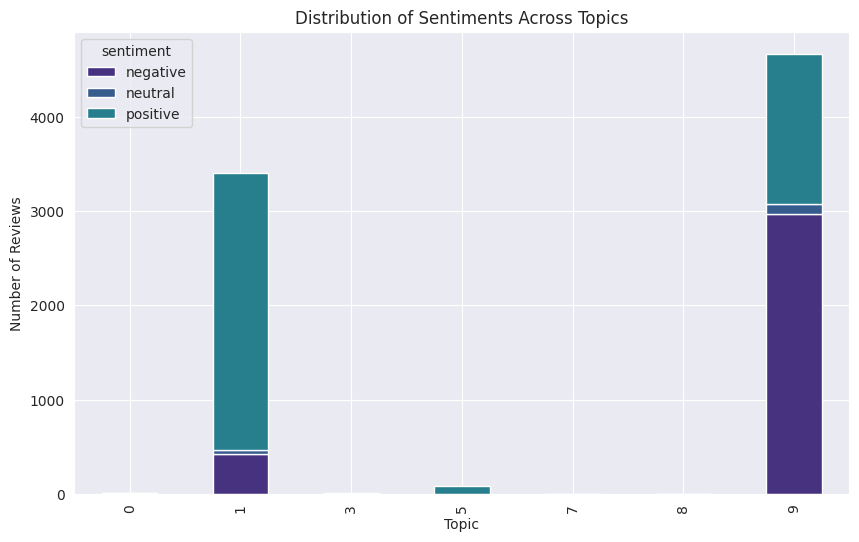

In [ ]:
# Assigning the dominant topic to each review
df['dominant_topic'] = lda.transform(tfidf_matrix).argmax(axis=1)

# Grouping by sentiment and dominant topic to analyze relationships
topic_sentiment_analysis = df.groupby(['dominant_topic', 'sentiment']
                                      ).size().unstack().fillna(0)
print(topic_sentiment_analysis)

# visualising this relationship
topic_sentiment_analysis.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Sentiments Across Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.show()


# Sentiment Analysis with BERT

In [ ]:
# Encoding the sentiment labels into numerical form
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

In [ ]:
# Spliting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned_Review'],
                                                    df['sentiment_encoded'],
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
# Defining a dataset class for BERT
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = self.reviews[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            review,
            max_length=self.max_len,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# Initialising the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Creating data loaders
train_dataset = ReviewsDataset(X_train.tolist(), y_train.tolist(),
                               tokenizer, max_len=128)
test_dataset = ReviewsDataset(X_test.tolist(), y_test.tolist(),
                              tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Training the BERT Model

In [ ]:
# Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=3)  # 3 classes, positive, negative, and neutral

# Defining training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In t

Step,Training Loss
10,1.032500
20,1.008800
30,0.949500
40,0.886400
50,0.797900
60,0.759200
70,0.697500
80,0.645700
90,0.626200
100,0.553200


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

TrainOutput(global_step=1227, training_loss=0.34286373800248177, metrics={'train_runtime': 478.4174, 'train_samples_per_second': 41.004, 'train_steps_per_second': 2.565, 'total_flos': 1290373978892544.0, 'train_loss': 0.34286373800248177, 'epoch': 3.0})

# Model Evaluation

In [ ]:
# Evaluate the model
trainer.evaluate()

# Predict sentiments on the test set
preds = trainer.predict(test_dataset)
preds = preds.predictions.argmax(-1)

# Evaluate performance
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy:.2f}")

precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='weighted')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy: 0.89
Precision: 0.88, Recall: 0.89, F1-Score: 0.88


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Topic Modeling with BERTopic
Installing and importing BERTopic



In [ ]:
!pip install bertopic

from bertopic import BERTopic

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
reviews = df['Cleaned_Review'].tolist()

# Initialising BERTopic
topic_model = BERTopic(embedding_model="paraphrase-MiniLM-L6-v2",
                       n_gram_range=(1, 2))

# Fitting the model and transforming reviews into topics
topics, probs = topic_model.fit_transform(reviews)

# Adding topics to the DataFrame
df['Topic'] = topics

# Visualizing the topics
topic_model.visualize_topics()

# Visualizing the distribution of topics
topic_model.visualize_barchart()


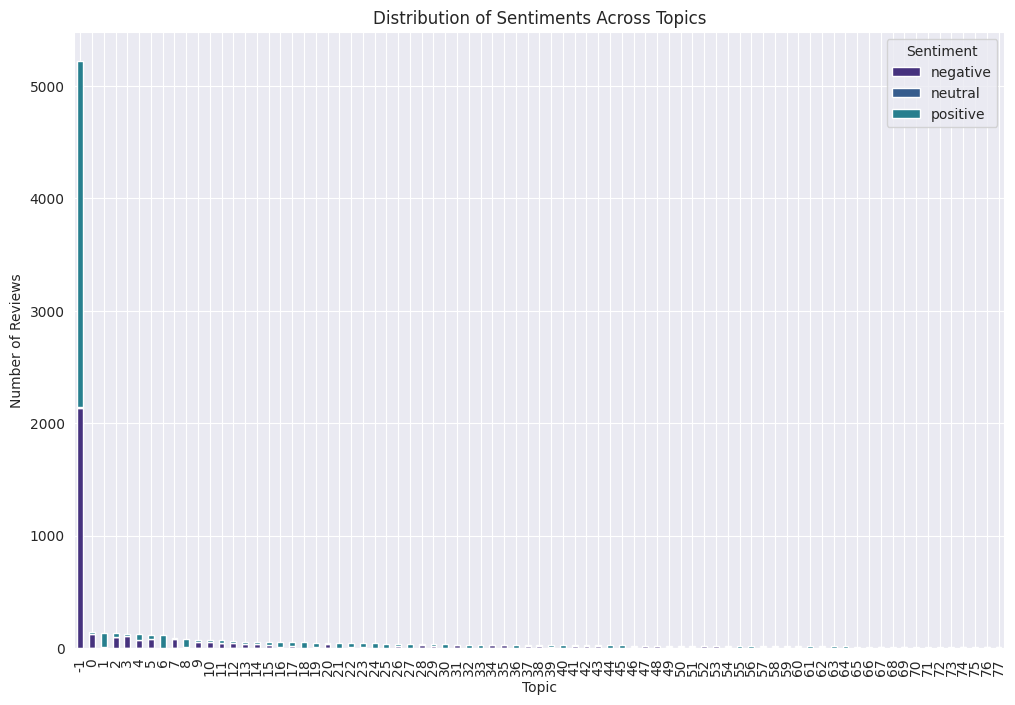

In [ ]:
# Predict sentiments for the entire dataset
dataset = ReviewsDataset(df['Cleaned_Review'].tolist(), df['sentiment_encoded'].tolist(), tokenizer, max_len=128)
loader = DataLoader(dataset, batch_size=16)

# Make predictions for all reviews
preds_full = trainer.predict(dataset)
preds_full = preds_full.predictions.argmax(-1)

# Add sentiment predictions to the entire DataFrame
df['Sentiment'] = label_encoder.inverse_transform(preds_full)

# Group by topic and sentiment to see the distribution
topic_sentiment_analysis = df.groupby(['Topic', 'Sentiment']).size().unstack().fillna(0)

# Plot the distribution
topic_sentiment_analysis.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribution of Sentiments Across Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.show()



In [ ]:
# Function to create descriptive names for each topic based on top words
def get_topic_name(model, topic_id, n_words=3):
    words_info = model.get_topic(topic_id)
    if words_info:
        words = [word for word, _ in words_info[:n_words]]
        topic_name = "_".join(words)
        return topic_name
    else:
        return f"Topic_{topic_id}"  # Fallback name if no words are found

# Create a dictionary to map topic numbers to topic names
topic_names = {i: get_topic_name(topic_model, i) for i in range(len(set(topics)))}

# Map topic numbers to names in the DataFrame
df['Topic_Name'] = df['Topic'].map(topic_names)


<Figure size 1400x1000 with 0 Axes>

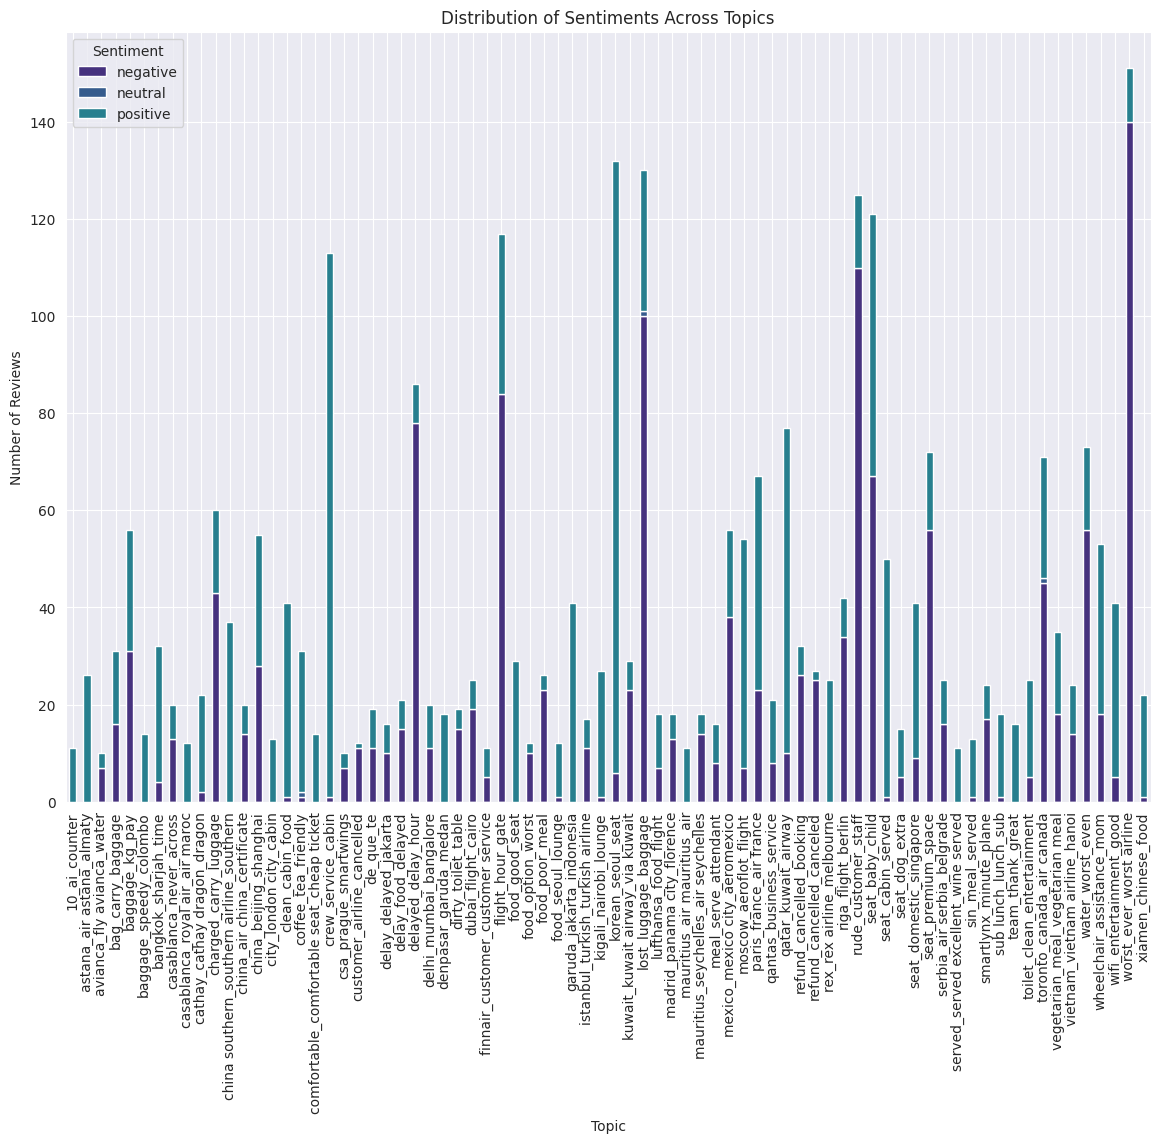

In [ ]:
# Group by topic names and sentiment to see the distribution
topic_sentiment_analysis = df.groupby(['Topic_Name', 'Sentiment']).size().unstack().fillna(0)

# Plot the distribution
plt.figure(figsize=(14, 10))
topic_sentiment_analysis.plot(kind='bar', stacked=True, figsize=(14, 10))
plt.title('Distribution of Sentiments Across Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.show()


In [ ]:
from bertopic import BERTopic

# Define your predefined topics and associated keywords
predefined_topics = {
    'In-flight meal': ['food', 'meal', 'service', 'menu'],
    'Entertainment': ['entertainment', 'movie', 'tv', 'screen'],
    'Seat comfort': ['seat', 'comfort', 'space', 'legroom'],
    # Add more as needed
}

# Use BERTopic with predefined topics
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df['Cleaned_Review'])

# Manually adjust or label topics based on your predefined topics
# This could involve reviewing the topics generated by BERTopic and mapping them to your predefined topics
# or using your keywords to guide the interpretation of each topic.




modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Visualize the refined topics
topic_model.visualize_topics()

Assigned_Topic
In-flight meal    5201
Other             1867
Seat comfort       857
Entertainment      249
Name: count, dtype: int64


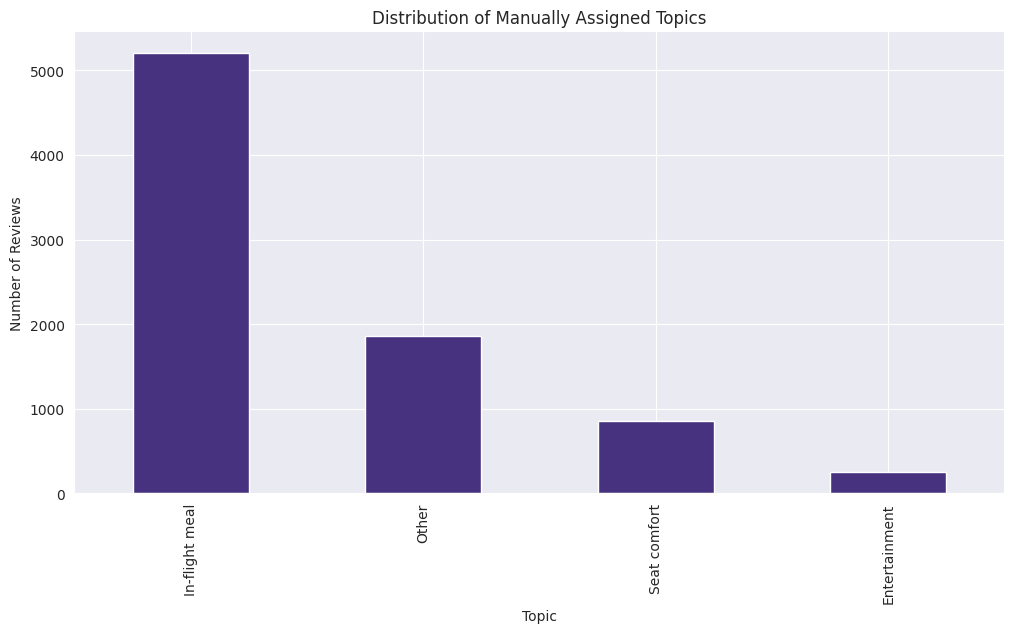

In [ ]:
# Define the keywords for each topic
topic_keywords = {
    'In-flight meal': ['food', 'meal', 'service', 'menu'],
    'Entertainment': ['entertainment', 'movie', 'tv', 'screen'],
    'Seat comfort': ['seat', 'comfort', 'space', 'legroom'],
    # Add more topics and keywords as needed
}

def assign_topic(review):
    for topic, keywords in topic_keywords.items():
        if any(keyword in review.lower() for keyword in keywords):
            return topic
    return 'Other'  # Default topic if no keywords match

# Apply the function to assign topics
df['Assigned_Topic'] = df['Cleaned_Review'].apply(assign_topic)

# Now you can analyze the assigned topics
topic_distribution = df['Assigned_Topic'].value_counts()
print(topic_distribution)

# Visualize the distribution of assigned topics
topic_distribution.plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of Manually Assigned Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.show()
